In [263]:
%pip install -q scipy numpy quantiphy pandas control


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [264]:
import scipy as sci
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import control
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from quantiphy import Quantity
import cmath


def polar2string(x: tuple[float, float]) -> str:
    return str((x[0])) + ' < ' +str(np.rad2deg(x[1])) + '°'

def complex2polar_string(x):
    return polar2string((np.abs(x), np.angle(x)))

# Converts a log value to a linear value
def log_2_linear(gain: float) -> float:
	return 10.0 ** (gain / 20.0)


# Converts a linear value to a log value
def linear_2_log(gain: float) -> float:
	return 20.0 * np.log10(gain)

# Prints a given parameter with its unit and using multipliers
def print_param(name: str, value: float, unit: str = "") -> None:
	print(name + ": " + str(Quantity(value, unit)))

# Prints a given parameter with its unit and using multipliers
def print_param_dict(name: str, dict: dict) -> None:
	print(name, ":")
	for key in dict:
		print("	", key + ": " + str(Quantity(dict[key])))


## Modeling a 3° cascade RC high pass filter

In [265]:
def zc(c: float, freq: float):
    xc = 1 / (2 * np.pi * freq * c)
    return 0 + (xc / 1j)

def zr(r: float, freq: float):
    return r + 0j

def parallel(z1, z2):
    return (z1 * z2) / (z1 + z2)

def series(z1, z2):
    return z1 + z2

# Gain of the 1° RC filter
def kn1(zr1, zr2, zr3, zc1, zc2, zc3):
    zeq = parallel(zr1, series(zc2, parallel(zr2, series(zc3, zr3))))
    return (zeq / (series(zc1, zeq)))

# Gain of the 2° RC filter
def kn2(zr1, zr2, zr3, zc1, zc2, zc3):
    zeq = parallel(zr2, series(zc3, zr3))
    return (zeq / (series(zc2, zeq)))

# Gain of the 3° RC filter
def kn3(zr1, zr2, zr3, zc1, zc2, zc3):
    return (zr3 / series(zc3, zr3))

def net(zr1, zr2, zr3, zc1, zc2, zc3):
    k1 = kn1(zr1, zr2, zr3, zc1, zc2, zc3)
    k2 = kn2(zr1, zr2, zr3, zc1, zc2, zc3)
    k3 = kn3(zr1, zr2, zr3, zc1, zc2, zc3)
    k = (k1 * k2 * k3)
    return k

def filter_model(freq: float, r1, r2, r3, c1, c2, c3):
    zr1 = zr(r1, freq)
    zr2 = zr(r2, freq)
    zr3 = zr(r3, freq)
    zc1 = zc(c1, freq)
    zc2 = zc(c2, freq)
    zc3 = zc(c3, freq)
    return net(zr1, zr2, zr3, zc1, zc2, zc3)

print(complex2polar_string(filter_model(1400, 18e3, 18e3, 18e3, 2.5784e-9, 2.5784e-9, 2.5784e-9)))



0.034483797972785696 < 179.99915397306222°


## modeling opamp


### Open simulation

In [266]:
df = pd.read_csv("analises/open_loop/example/open_loop_gain.csv", index_col="frequency")
df.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64511 entries, 0 to 64510
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frequency  64511 non-null  float64
 1   gain       64511 non-null  float64
 2   phase      64511 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


### Create Model

The open-loop behavior of an op-amp is similar to an ideal amplifier with a low-pass filter in the output. Therefore, a simplified model of an LM324 op-amp can be represented as an ideal op-amp with an RC filter in the output.

<img src="analises/assets/lm324_model.png">

In [267]:
# Create the transfer function of a theoretical low pass filter
def get_n1_low_pass_filter(r: float, c: float, gain: float) -> control.TransferFunction:
	w0 = 1 / (r * c)

	num = [0, -gain]
	den = [1 / -w0, 1]
	return control.TransferFunction(num, den)

def get_opamp_model_output(r: float, c: float, open_loop_gain: float, frequency):
	return get_n1_low_pass_filter(r, c, open_loop_gain).frequency_response(2 * np.pi * frequency)


### Plot Opamp Model example

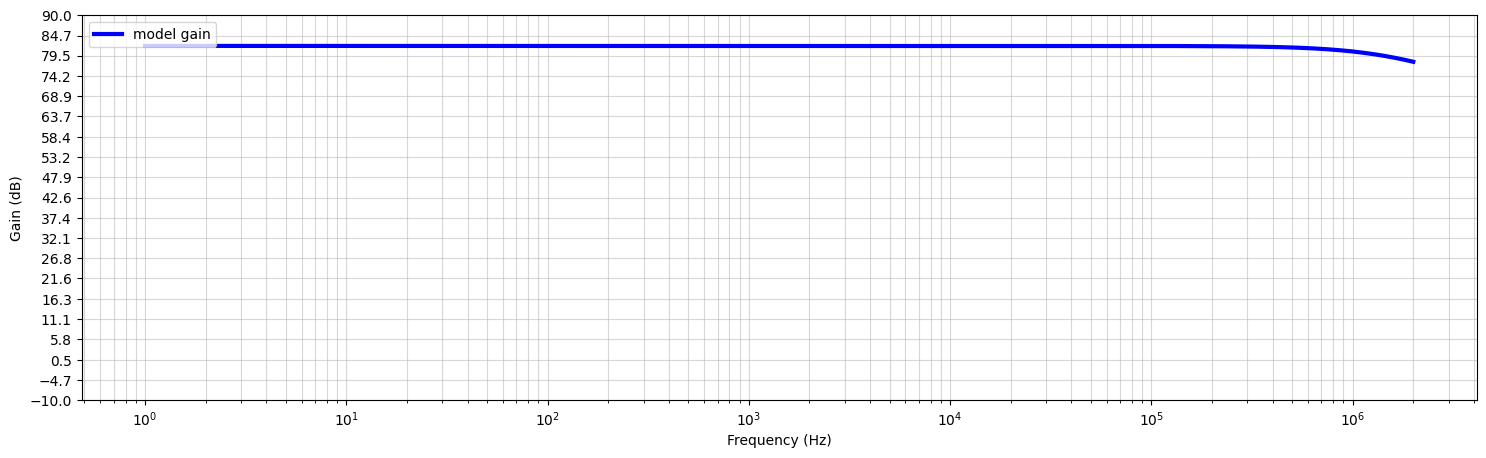

In [268]:

mag, phase, omega = get_opamp_model_output(100, 1e-9, log_2_linear(82), df.index)
fig, ax = plt.subplots(figsize = (18, 5))

# plot gain
ax.plot(
	df.index,
	linear_2_log(mag),
	label = "model gain",
	color = "b",
	linewidth = 3.0
)

# general ax configuration 
ax.set_xscale('log', base = 10)
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks(np.round(np.linspace(-10, 90, 20), 1))

### Fit the model with the simulation data

Measuring the open-loop gain through the AC analysis can be challenging due to the possibility of errors generated by the DC offset. 
To overcome this, we can use Michael Tian's method as demonstrated in this [video](https://www.youtube.com/watch?v=bXbDa9nglZI) and explained in more detail in this [paper](https://kenkundert.com/docs/cd2001-01.pdf).

Simulation:
<img src="analises/assets/lm324_open_loop_simulation.png">

#### Curve fit 

When using the SciPy curve fit function, it is important to note that it can only have one floating-point value as the output. This means that either the gain or the phase can be fitted, but not both simultaneously.

In [282]:
# Opamp RC model with gain as independent variable, this function is for scipy curve fit
def filter_model_gain(x, r, c, open_loop_gain):
    c = c
    r = r
    open_loop_gain = abs(open_loop_gain)
    mag, phase, omega = get_opamp_model_output(r, c, log_2_linear(open_loop_gain), x)
    return mag

# Opamp RC model with gain as independent variable, this function is for scipy curve fit
def filter_model_phase(x, r, c, open_loop_gain):
    c = abs(c)
    r = abs(r)
    open_loop_gain = abs(open_loop_gain)
    mag, phase, omega = get_opamp_model_output(r, c, log_2_linear(open_loop_gain), x)
    return np.rad2deg(phase)

popt, pcov = curve_fit(filter_model_gain, df.index, log_2_linear(df.gain), [300, 50e-9, 80], bounds=(0, [100e3, 10e-6, 200]))

r = abs(popt[0])
c = abs(popt[1])
open_loop_gain = abs(popt[2])


print("Lm324 model")
print_param("R", popt[0], "R")
print_param("C", abs(popt[1]), "F")
print_param("open_loop_gain", popt[2], "dB")



Lm324 model
R: 40.464 R
C: 273.08 nF
open_loop_gain: 40.099 dB


#### Plotting results

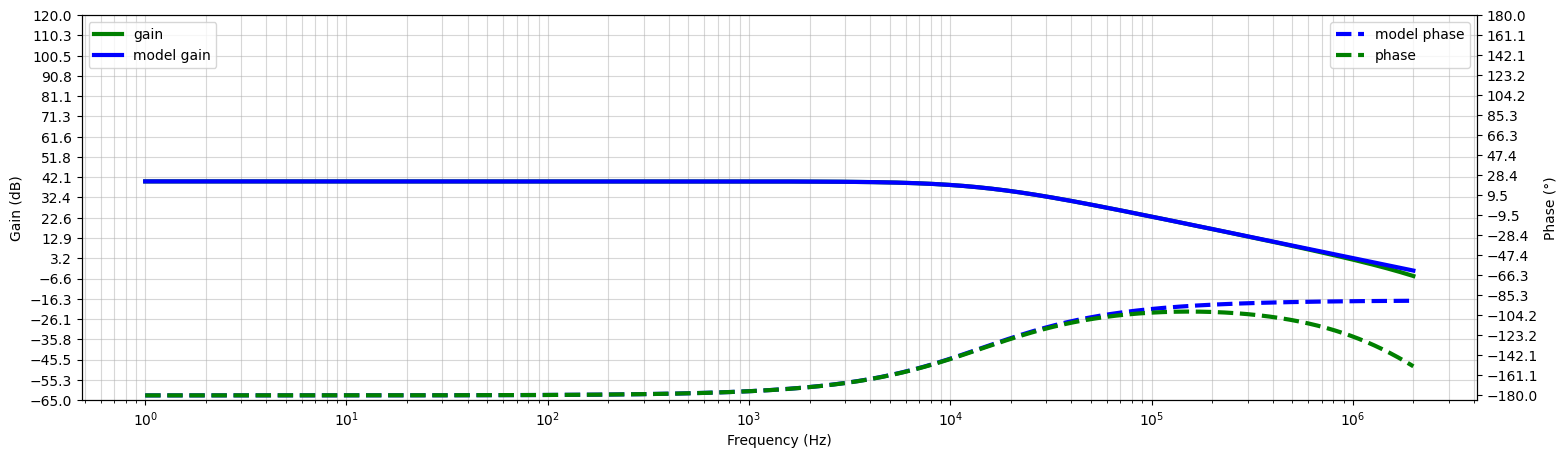

In [270]:
fig, ax = plt.subplots(figsize = (18, 5))

mag, phase, omega = get_opamp_model_output(r, c, log_2_linear(open_loop_gain), df.index)

df.plot(
	ax = ax,
	y = ["gain"],
	color = ["g"],
	lw = 3.0,
)

ax.plot(
	df.index,
	linear_2_log(mag),
	label = "model gain",
	color = "b",
	linewidth = 3.0
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	df.index,
	np.rad2deg(np.array(phase)),
	label = "model phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

df.plot(
	ax = ax2,
	y = ["phase"],
	style = ["--"],
	color = ["g"],
	lw = 3.0
)


# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks(np.round(np.linspace(-65, 120, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)



### Modeling the inverting opamp

**Utilizando analise de malha**

$ V_+ = V_{in} $

Divisor de tensão entre $ V_{out} $ e $ V_- $

$ V_- = \frac{Vout * R1}{Rf + R1 + R_{out}} $

Pelo modelo do ampop

$ V_{out} = Av * (V_+ - V_-) $

Substituindo

$ V_{out} = Av * (V_{in} - \frac{Vout * R1}{Rf + R1 + R_{out}}) $

Distribuindo Av

$ V_{out} = Av * V_{in} - \frac{Vout * R1 * Av}{Rf + R1 + R_{out}} $

Isolando $ V_{out} $

$ V_{out} - Av * V_{in} =  - \frac{Vout * R1 * Av}{Rf + R1 + R_{out}} $

$ V_{in} = V_{out} * (\frac{1}{Av} + \frac{R1}{Rf + R1 + R_{out}}) $

Isolando $ R_{out} $ da fração

$ V_{in} = V_{out} * (\frac{1}{Av} + \frac{1}{\frac{R1 + Rf}{R1} + \frac{R_{out}}{R1}}) $

Como $ \frac{R1 + Rf}{R1} $ é igual ao ganho teorico $ G $ pode ser substituido $ \frac{R1 + Rf}{R1} $ por $ G $ 

$ V_{in} = V_{out} * (\frac{1}{Av} + \frac{1}{G + \frac{R_{out}}{R1}}) $

$ \frac{1}{G_{real}} = (\frac{1}{Av} + \frac{1}{G + \frac{R_{out}}{R1}}) $

$ G_{real} = (\frac{1}{Av} + \frac{1}{G + \frac{R_{out}}{R1}})^{-1} $

In [271]:
def inverting_opamp_model(r1, rf, r_opamp, c_opamp, open_loop_gain, frequency):
	# Get intrinsic gain and phase of the opamp
	Aov_mag, Aov_phase, omega = get_opamp_model_output(r_opamp, c_opamp, open_loop_gain, frequency)

	# Classic inverting amplifier gain with opamp
	G_abs = ((r1 + rf) / r1)
	G_real_abs = 1 / ((1 / G_abs) + (1 / Aov_mag))
	G_real_phase = Aov_phase
	
	return G_real_abs * np.exp(1j * G_real_phase)


#### Example using a inverting amplifier with gain 2 V/V

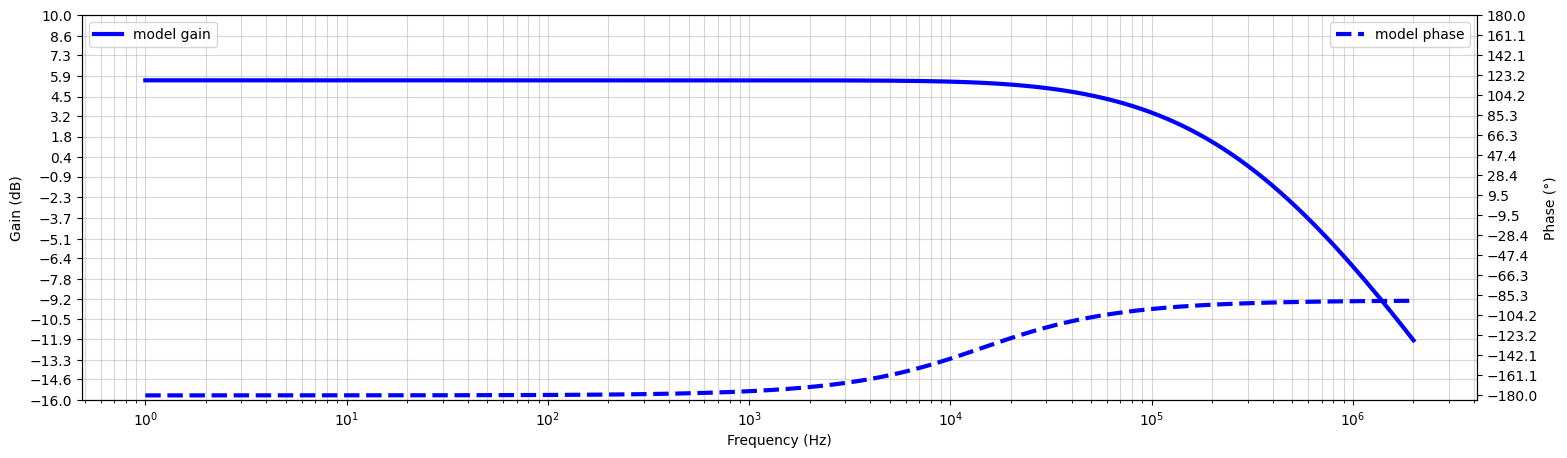

In [272]:
fig, ax = plt.subplots(figsize = (18, 5))

g_real = inverting_opamp_model(10e3, 10e3, r, c, open_loop_gain, df.index)

ax.plot(
	df.index,
	linear_2_log(np.abs(g_real)),
	label = "model gain",
	color = "b",
	linewidth = 3.0
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	df.index,
	np.rad2deg(np.angle(g_real)),
	label = "model phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks(np.round(np.linspace(-16, 10, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)

# Optimizing oscillator

## Oscilator Model

The Barkhausen criteria is a set of conditions that must be satisfied for an oscillator to maintain oscillations. There are two conditions:
- The loop gain around the feedback loop should be equal to 1 at the frequency of oscillation.
- The phase shift around the feedback loop should be an integer multiple of 360 degrees.

In other words, the feedback signal must be in phase with the input signal and its magnitude must be equal to or greater than the input signal for the oscillation to be sustained.

In [281]:
def oscillator_total_gain(frequency, opamp: dict, filter: dict):
	k_opamp = inverting_opamp_model(opamp["r1"], opamp["rf"], opamp["r_opamp"], opamp["c_opamp"], opamp["open_loop_gain"], frequency)
	k_filter = filter_model(frequency, filter["r1"], filter["r2"], filter["r3"], filter["c1"], filter["c2"], filter["c3"])
	# the total gain of an oscilator is the opamp gain vs passive filter gain 
	return k_opamp * k_filter

lm324 = {
    "r1":1e3,
	"rf": 10e3,
	"r_opamp": r,
	"c_opamp": c,
	"open_loop_gain": open_loop_gain,
	}

filter = {
    "r1": 18e3,
	"r2": 18e3,
	"r3": 18e3,
	"c1": 2.5784e-9,
	"c2": 2.5784e-9,
	"c3": 2.5784e-9,
	}
print(complex2polar_string(oscillator_total_gain(1400, lm324, filter)))

[0.29736379] < [5.55098888]°


## Using scipy to archive the Barkhausen criteria

### Phase

In [286]:
def total_phase_to_optimize(x: np.ndarray, opamp: dict, filter: dict, frequency) -> float:
	filter["r1"] = filter["r2"] = filter["r3"] = x[0]
	# The optimizer seems to reduce de error if the capacitor is in nF instead of F
	filter["c1"] = filter["c2"] = filter["c3"] = x[1] / 1e9
	return np.abs(np.angle(oscillator_total_gain(frequency, opamp, filter)))


lm324 = {
	# input resistor 
    "r1":10e3,
    # feedback resistor 
	"rf": 10e3,
	# resistor of the RC output filter model
	"r_opamp": r,
	# capacitor of the RC output filter model
	"c_opamp": c,
	# open loop gian of the RC output filter model
	"open_loop_gain": open_loop_gain,
	}

filter = {
    "r1": 18e3,
	"r2": 18e3,
	"r3": 18e3,
	"c1": 2.5784e-9,
	"c2": 2.5784e-9,
	"c3": 2.5784e-9,
	}

frequency_target = 1000

res = sci.optimize.minimize(total_phase_to_optimize, [18e3, 2.5784], (lm324, filter, frequency_target), bounds=((100, 10e3), (0.1, 100)))



print("Passive components to archive the phase of the Barkhausen criteria")
print_param("final phase", np.rad2deg(total_phase_to_optimize(res.x, lm324, filter, frequency_target)), "°")
print_param_dict("filter", filter)
print_param_dict("lm324", lm324)


Passive components to archive the phase of the Barkhausen criteria
final phase: 24.742n°
filter :
	 r1: 10k
	 r2: 10k
	 r3: 10k
	 c1: 6.9554n
	 c2: 6.9554n
	 c3: 6.9554n
lm324 :
	 r1: 10k
	 rf: 10k
	 r_opamp: 40.464
	 c_opamp: 273.08n
	 open_loop_gain: 40.099


### Gain

In [287]:
def total_gain_to_optimize(x: np.ndarray, wanted_gain, opamp: dict, filter: dict, frequency) -> float:
	lm324["rf"] = x[0]
	#print(np.abs(oscillator_total_gain(frequency, opamp, filter) - wanted_gain) )
	return np.abs(linear_2_log(oscillator_total_gain(frequency, opamp, filter) - wanted_gain)) 

filter["r3"] = filter["r2"] * 2
lm324["r1"] = filter["r3"]

res = sci.optimize.minimize(total_gain_to_optimize, 1e6, (0, lm324, filter, frequency_target), tol=1e-88, bounds=((51e3, 100e6), ), method="L-BFGS-B")

print("Passive components to archive the phase of the Barkhausen criteria")
print_param("final gain", total_gain_to_optimize(res.x, 0, lm324, filter, frequency_target), "V/V")
print_param("error", 100 / total_gain_to_optimize(res.x, 0, lm324, filter, frequency_target), "V/V")
print_param_dict("filter", filter)
print_param_dict("lm324", lm324)

Passive components to archive the phase of the Barkhausen criteria
final gain: 1.872 V/V
error: 53.42 V/V
filter :
	 r1: 10k
	 r2: 10k
	 r3: 20k
	 c1: 6.9554n
	 c2: 6.9554n
	 c3: 6.9554n
lm324 :
	 r1: 20k
	 rf: 476.88k
	 r_opamp: 40.464
	 c_opamp: 273.08n
	 open_loop_gain: 40.099


In [288]:
print("simulation parameters:")
string = f'.param C={Quantity(filter["c1"])} R={Quantity(filter["r3"])} RH={Quantity(filter["r2"])} RF={Quantity(lm324["rf"])} RF_var=1'
string = string.replace("M", "Meg")
print(string)

simulation parameters:
.param C=6.9554n R=20k RH=10k RF=476.88k RF_var=1
